## Importing Libraries and Loading Our Data

In [3]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS


sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [181]:
df=pd.read_csv('../data/eda.csv')


C:\Users\kiran\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Regression: Predicting Movie Revenues

In this section, I will attempt at building a regression model to predict movie revenues. Since this isn't one of the main goals of this project, I will not spend too much time feature engineering or hyperparamater tuning my model.

We will be using TMDB's Popularity Score and Vote Average as our features in our model to assign a nuerical value to popularity

In [150]:
rgf = df[df['return'].notnull()]
rgf.shape

(6781, 30)

We have **5393 records** in our training set. Let us take a look at the features we possess and remove the ones which are unnecessary.

In [151]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [152]:
rgf = rgf.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'video', 'return', 'crew'], axis=1)

We will perform the following feature engineering tasks:

1. **belongs_to_collection** will be turned into a Boolean variable. 1 indicates a movie is a part of collection whereas 0 indicates it is not.
2. **genres** will be converted into number of genres.
3. **homepage** will be converted into a Boolean variable that will indicate if a movie has a homepage or not.
4. **original_language** will be replaced by a feature called **is_foreign** to denote if a particular film is in English or a Foreign Language.
5. **production_companies** will be replaced with just the number of production companies collaborating to make the movie.
6. **production_countries** will be replaced with the number of countries the film was shot in.
7. **day** will be converted into a binary feature to indicate if the film was released on a Friday.
8. **month** will be converted into a variable that indicates if the month was a holiday season.

In [153]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_rgf = rgf.drop('genres', axis=1).join(s)
genres_train = gen_rgf['genre'].drop_duplicates()

C:\Users\kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [154]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [155]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [156]:
X = feature_engineering(X)

In [157]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [158]:
X.shape

(6781, 37)

In [159]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.7970529752104314

We get a Coefficient of Determination of **0.79** which is a pretty score for the basic model that we have built. Let us compare our model's score to a Dummy Regressor.

In [160]:
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

-8.012080680108724e-05

We see that our model performs far more superiorly than the Dummy Regressor. Finally, let us plot the feature importances in the form of a bar plot to deduce which features were the most significant in our making predictions.

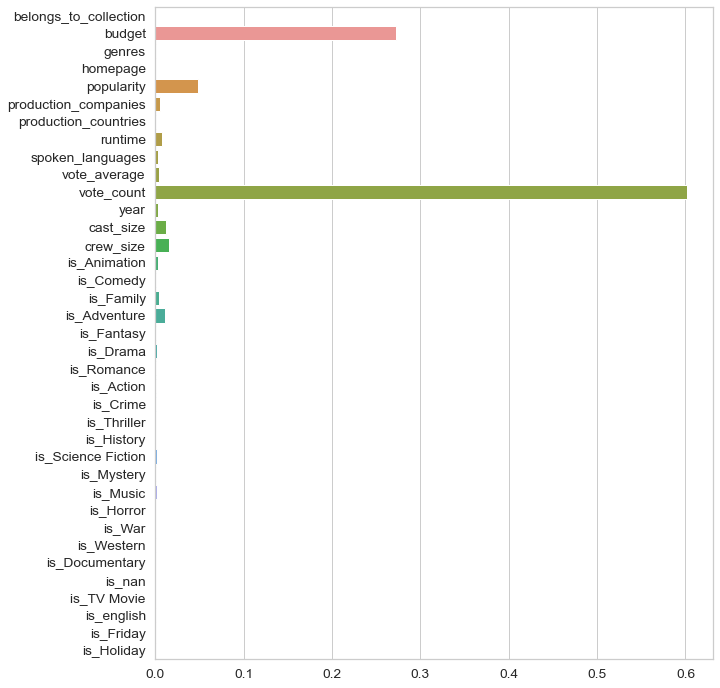

In [161]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

We notice that **vote_count**, a feature we *cheated* with, is the most important feature to our Gradient Boosting Model. This goes on to show the improtance of popularity metrics in determining the revenue of a movie. **Budget** was the second most important feature followed by **Popularity**.

## Classification: Predicting Movie Sucess

What factors influence whether a movie will be able to make blockbuster? I will try to answer this question by building a binary classifier that predicts if a movie will make a profit or a loss.

In [162]:
cls = df[df['return'].notnull()]
cls.shape

(6781, 30)

In [163]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'day', 'month',
       'cast', 'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [164]:
cls = cls.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'revenue'], axis=1)

Let us convert our **return** feature into a binary variable that will serve as our classes: **0** indicating a flop and **1** indicating a hit.

In [165]:
cls['return'] = cls['return'].apply(lambda x: 1 if x >=1 else 0)

In [166]:
cls['return'].value_counts()

1    4747
0    2034
Name: return, dtype: int64

Our classes seem to be fairly balanced. We do not need to apply any additional methods to deal with the imbalance of classes. Let us now turn our attention to our features.

In [167]:
cls['belongs_to_collection'] = cls['belongs_to_collection'].fillna('').apply(lambda x: 0 if x == '' else 1)

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1259: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


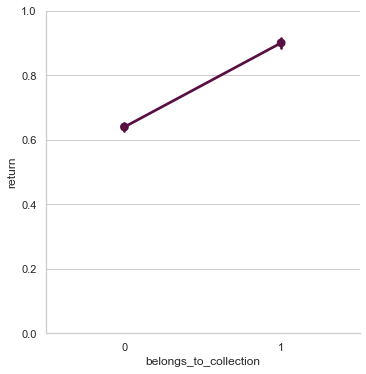

In [168]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='return', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

It seems that movies that belong to a franchise have a higher probability of being a success. 

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1259: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


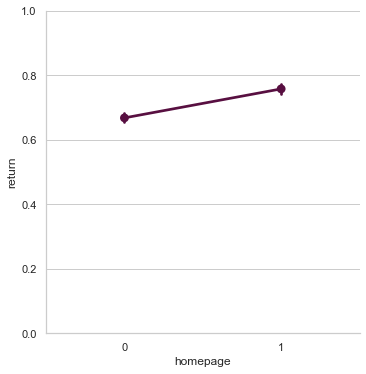

In [169]:
cls['homepage'] = cls['homepage'].fillna('').apply(lambda x: 0 if x == '' else 1)
g = sns.PairGrid(data=cls, x_vars=['homepage'], y_vars='return', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We see that with homepages, there is not a very huge difference in probability. To avoid the curse of dimensionality, we will eliminate this feature as it is not very useful.

In [170]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

C:\Users\kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


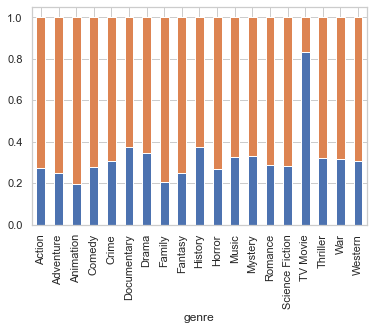

In [171]:
ctab = pd.crosstab([gen_cls['genre']], gen_cls['return'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
ctab.plot(kind='bar', stacked=True, legend=False)

We find that **TV Movies** have a less Failure Rate but that is most probably because they are extremely few in numner. 

In [172]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'title', 'video',
       'vote_average', 'vote_count', 'return', 'year', 'day', 'month', 'cast',
       'crew', 'cast_size', 'crew_size', 'director'],
      dtype='object')

In [173]:
def classification_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))
    df = df.drop('homepage', axis=1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director'], axis=1)
    #df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    df = df.drop('crew', axis=1)
    return df
    

In [174]:
cls = classification_engineering(cls)

In [175]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'popularity',
       'production_companies', 'production_countries', 'runtime',
       'spoken_languages', 'video', 'vote_average', 'vote_count', 'return',
       'year', 'cast_size', 'crew_size', 'is_Animation', 'is_Comedy',
       'is_Family', 'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance',
       'is_Action', 'is_Crime', 'is_Thriller', 'is_History',
       'is_Science Fiction', 'is_Mystery', 'is_Music', 'is_Horror', 'is_War',
       'is_Western', 'is_Documentary', 'is_nan', 'is_TV Movie', 'is_english',
       'is_Friday', 'is_Holiday'],
      dtype='object')

In [176]:
X, y = cls.drop('return', axis=1), cls['return']

In [177]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [178]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

0.7783018867924528

Our basic Gradient Boosting Classifier has an accuracy of **77%**. Again, this model can be improved upon through hyperparameter tuning and more advanced feature engineering but since this is not the main objective of this project, I will skip this.

In [179]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

0.6998820754716981

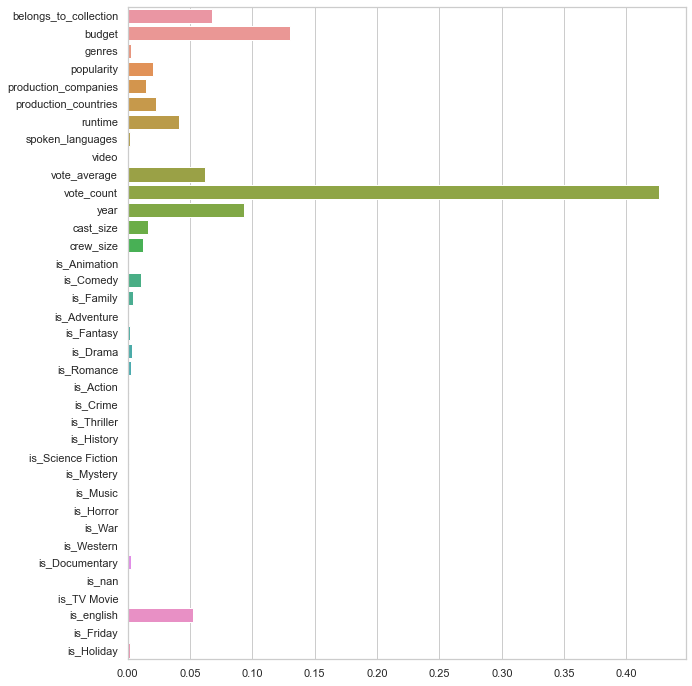

In [180]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

We see that **Vote Count** is once again the most significant feature identified by our Classifier. Other important features include **Budget**, **belongs_to_collection** and **Year**. With this, we will conclude our discussion on the classification model and move on to the main part of the project.

In the next notebook, I will try to build a **Hybrid Recommendation System** based on popularity, content and collaborative filtering. This will use the MovieLens dataset in addition to the TMDB Movies Metadata that we have used here.